## 导入库

In [1]:
# coding:UTF-8
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from sklearn.metrics import confusion_matrix
from tensorflow.examples.tutorials.mnist import input_data
data = input_data.read_data_sets("MNIST-data", \
                                 one_hot=True)

Extracting MNIST-data/train-images-idx3-ubyte.gz
Extracting MNIST-data/train-labels-idx1-ubyte.gz
Extracting MNIST-data/t10k-images-idx3-ubyte.gz
Extracting MNIST-data/t10k-labels-idx1-ubyte.gz


In [2]:
print "训练数据共："+str(len(data.train.images))
print "测试数据共："+str(len(data.test.images))
print "第一个测试图的维度："+str(data.test.images[0].shape)
print "第一个测试图的真实值："+str(data.test.labels[0])

训练数据共：55000
测试数据共：10000
第一个测试图的维度：(784,)
第一个测试图的真实值：[ 0.  0.  0.  0.  0.  0.  0.  1.  0.  0.]


In [4]:
def plot_images(images, cls_true, cls_pred=None):
    assert len(images) == len(cls_true) == 9
    
    # Create figure with 3x3 sub-plots.
    fig, axes = plt.subplots(3, 3)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)

    for i, ax in enumerate(axes.flat):
        # Plot image.
        ax.imshow(images[i].reshape((28,28)), cmap='binary')

        # Show true and predicted classes.
        if cls_pred is None:
            xlabel = "label: {0}".format(cls_true[i])
        else:
            xlabel = "True: {0}, Pred: {1}".format(cls_true[i], cls_pred[i])

        ax.set_xlabel(xlabel)
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])

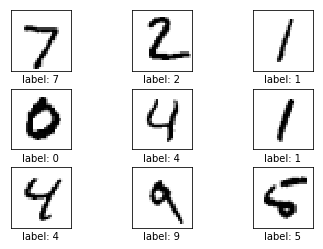

In [5]:
# Get the first images from the test-set.
images = data.test.images[0:9]

# Get the true classes for those images.
cls_true = np.argmax(data.test.labels[0:9],1)

# Plot the images and labels using our helper-function above.
plot_images(images=images, cls_true=cls_true)

In [6]:
input_x = tf.placeholder(dtype=tf.float32,shape=[None,28*28])
weights = tf.Variable(tf.zeros([28*28,10]))
biases = tf.Variable(tf.zeros([10]))

logits = tf.matmul(input_x,weights)+biases
y_pred = tf.nn.softmax(logits=logits)
y_pred_cls = tf.arg_max(y_pred,1)

y_true = tf.placeholder(dtype=tf.float32,shape=[None,10])
y_true_cls = tf.placeholder(dtype=tf.int64,shape=[None])

cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=y_true,logits=logits)
cost = tf.reduce_mean(cross_entropy)

optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.5).minimize(cost)

In [7]:
session = tf.Session()
session.run(tf.global_variables_initializer())

In [8]:
batch_size = 100
def optimize(num):
    for i in range(num):
        input_x_batch,y_true_batch = data.train.next_batch(batch_size)
        feed_dict_batch = {
            input_x:input_x_batch,
            y_true:y_true_batch
        }
        session.run(optimizer,feed_dict=feed_dict_batch)

In [9]:
whether_equals = tf.equal(y_pred_cls,y_true_cls)

accuracy_formula = tf.reduce_mean(tf.cast(whether_equals,dtype=tf.float32))
def print_accuracy():
    feed_dic_test ={
        input_x:data.test.images,
        y_true:data.test.labels,
        y_true_cls:np.argmax(data.test.labels,1)
    }
    accuracy= session.run(accuracy_formula,feed_dict=feed_dic_test)
    print "准确率：{:0.1%}".format(accuracy)



In [10]:
print_accuracy()

准确率：9.8%


In [11]:
def plot_weights():
    # Get the values for the weights from the TensorFlow variable.
    w = session.run(weights)
    
    # Get the lowest and highest values for the weights.
    # This is used to correct the colour intensity across
    # the images so they can be compared with each other.
    w_min = np.min(w)
    w_max = np.max(w)

    # Create figure with 3x4 sub-plots,
    # where the last 2 sub-plots are unused.
    fig, axes = plt.subplots(3, 4)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)

    for i, ax in enumerate(axes.flat):
        # Only use the weights for the first 10 sub-plots.
        if i<10:
            # Get the weights for the i'th digit and reshape it.
            # Note that w.shape == (img_size_flat, 10)
            image = w[:, i].reshape((28,28))

            # Set the label for the sub-plot.
            ax.set_xlabel("Weights: {0}".format(i))

            # Plot the image.
            ax.imshow(image, vmin=w_min, vmax=w_max, cmap='seismic')

        # Remove ticks from each sub-plot.
        ax.set_xticks([])
        ax.set_yticks([])
        
        

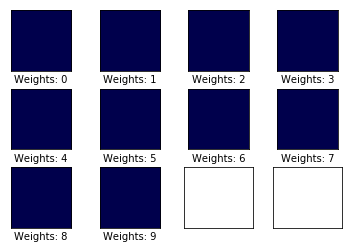

In [12]:
plot_weights()

In [13]:
print session.run(biases)

[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]


准确率：27.5%


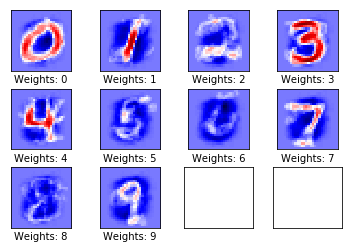

In [14]:
optimize(1)
print_accuracy()
plot_weights()

In [15]:

def plot_example_errors():
    data.test.cls = data.test.cls = np.array([label.argmax() for label in data.test.labels])
    # Use TensorFlow to get a list of boolean values
    # whether each test-image has been correctly classified,
    # and a list for the predicted class of each image.
    feed_dict_test = {input_x: data.test.images,
                  y_true: data.test.labels,
                  y_true_cls: data.test.cls}
    correct, cls_pred = session.run([whether_equals, y_pred_cls],
                                    feed_dict=feed_dict_test)

    # Negate the boolean array.
    incorrect = (correct == False)
    
    # Get the images from the test-set that have been
    # incorrectly classified.
    images = data.test.images[incorrect]
    
    # Get the predicted classes for those images.
    cls_pred = cls_pred[incorrect]

    # Get the true classes for those images.
    cls_true = data.test.cls[incorrect]
    
    # Plot the first 9 images.
    plot_images(images=images[0:9],
                cls_true=cls_true[0:9],
                cls_pred=cls_pred[0:9])

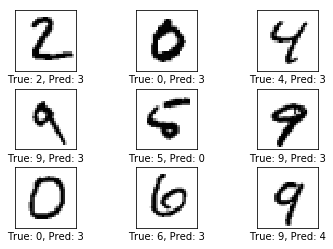

In [16]:
plot_example_errors()

准确率：77.1%


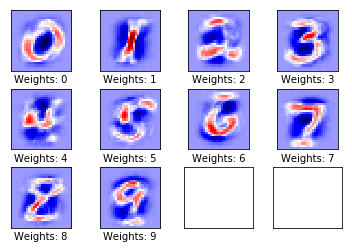

In [17]:
optimize(9)
print_accuracy()
plot_weights()

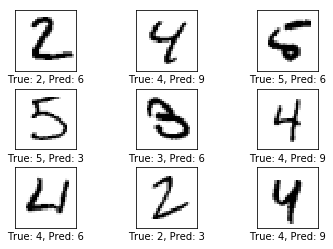

In [18]:
plot_example_errors()

准确率：91.4%


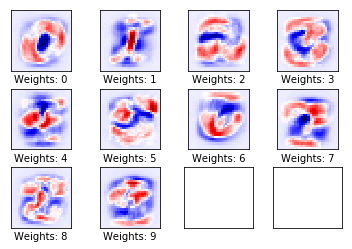

In [19]:
optimize(540)
print_accuracy()
plot_weights()

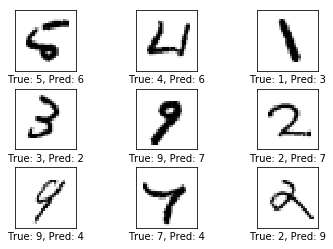

In [20]:
plot_example_errors()

In [25]:
def print_confusion_matrix():
    num_classes=10
    # Get the true classifications for the test-set.
    data.test.cls = data.test.cls = np.array([label.argmax() for label in data.test.labels])
    cls_true = data.test.cls
    feed_dict_test = {input_x: data.test.images,
                  y_true: data.test.labels,
                  y_true_cls: data.test.cls}
    
    # Get the predicted classifications for the test-set.
    cls_pred = session.run(y_pred_cls, feed_dict=feed_dict_test)

    # Get the confusion matrix using sklearn.
    cm = confusion_matrix(y_true=cls_true,
                          y_pred=cls_pred)

    # Print the confusion matrix as text.
    print(cm)

    # Plot the confusion matrix as an image.
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)

    # Make various adjustments to the plot.
    plt.tight_layout()
    plt.colorbar()
    tick_marks = np.arange(num_classes)
    plt.xticks(tick_marks, range(num_classes))
    plt.yticks(tick_marks, range(num_classes))
    plt.xlabel('Predicted')
    plt.ylabel('True')

[[ 967    0    0    2    0    4    5    1    1    0]
 [   0 1105    2    6    1    3    4    1   13    0]
 [  14    7  909   15   12    3   14   13   37    8]
 [   4    0   22  927    0   27    2   11    7   10]
 [   2    1    2    1  910    0   16    2    5   43]
 [  11    3    1   36    9  782   15    6   19   10]
 [  19    3    3    2   10   18  901    1    1    0]
 [   5    8   20    9    7    1    0  944    1   33]
 [  13    8   12   43    9   42   17   16  794   20]
 [  14    5    3   13   36    9    0   27    2  900]]


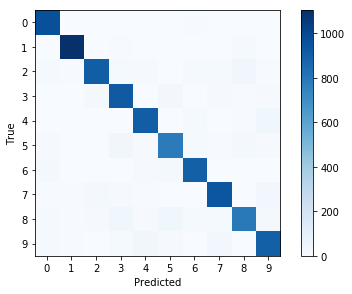

In [26]:
print_confusion_matrix()